# Overview
The data was initially provided in a sqlite database.

# Initial Data Preparation

In [1]:
# a small piece of code to find the data folder
import os, importlib
from pathlib import Path

NOTEBOOK_SCRIPT = os.getcwd()

current = NOTEBOOK_SCRIPT
while 'data' not in os.listdir(current):
    current = Path(current).parent

DATA_FOLDER = os.path.join(current, 'data')

In [2]:
# let's extract all the features needed in the data. 
import data_preparation as dpre
importlib.reload(dpre)


db_file = os.path.join(DATA_FOLDER, 'F24.ML.Assignment.One.data.db')
df_save_file = os.path.join(DATA_FOLDER, 'data.csv')
df = dpre.data_to_df(db_file, 
           df_save_file, 
           overwrite=False # no need to execute the same lengthy query if the .csv file already exists...
           )

In [3]:
df.head()

,order_id,start_prep_date,finish_prep_date,profit,delivery_distance,status_id,planned_prep_time,product_id,store_id,price
0,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99278,3750,26.07
1,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99283,3750,7.11
2,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99285,3750,7.11
3,18671225,2024-05-08 00:02:01,2024-05-08 00:10:29,15.800,560,F,15.0,298529,5863,31.60
4,18671227,2024-05-08 00:01:50,2024-05-08 00:49:19,6.004,4396,F,20.0,399309,8721,30.02


## Observations


* the preparation time (in mintues) which is defined as the difference between finish_prep_data and start_prep_date is common between all items in the same order. In this case it is important to have disjoint sets of orders in the train and test dataset to avoid data leakage. A SOPHITICATED MODEL (SUCH AS NEURAL NETWORK) CAN EASILY MEMORIZE THE ORDER ID, MAP IT TO ITS LABEL.

* if the price + product_id do not provide any useful insights. I will keep only the information on the order-level reducing the number of samples.


# Data Preparation

## Missing data
Before moving to data splitting, it is necessary to make sure the 'fields' needed to compute the label are not missing.

In [4]:
import pandas as pd
import numpy as np
missing_data = np.mean(df.isna(), axis=0)
missing_data

order_id             0.000000
start_prep_date      0.000000
finish_prep_date     0.000000
profit               0.099278
delivery_distance    0.000000
status_id            0.000000
planned_prep_time    0.000004
product_id           0.000000
store_id             0.000000
price                0.100164
dtype: float64

The data has been prepared (with SQL) such that for a single order neither `finish_prep_date` nor `start_prep_date` would be missing and the natural relation `finish_prep_date` > `start_prep_date` is preserved. The label for a given order is the difference of these two values and hence a missing value in one of them would mean a missing label. Imputing missing labels is highly discouraged as it is prone to introduce bias according to [Multivariate Analysis](https://www.drnishikantjha.com/papersCollection/Multivariate%20Data%20Analysis.pdf).

Since `planned_prep_time` is intuitively a very good indicator of the actual preparation time, we will also remove the very few samples with missing `planned_prep_time`. 

In [5]:
importlib.reload(dpre)
samples_with_missing = dpre.samples_with_missing_data(df, columns=['planned_prep_time'], missing_data_rel='or', objective='locate')
print(f"missing ratio: {len(samples_with_missing) / len(df)}") 

# we are barely losing any data...
df = dpre.samples_with_missing_data(df, columns=['planned_prep_time'], missing_data_rel='or', objective='remove')

# prepare the date
df = dpre.prepare_labels(df)
df.head()

missing ratio: 3.6493553413789454e-06


,order_id,start_prep_date,finish_prep_date,profit,delivery_distance,status_id,planned_prep_time,product_id,store_id,price,y
0,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99278,3750,26.07,23.0
1,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99283,3750,7.11,23.0
2,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99285,3750,7.11,23.0
3,18671225,2024-05-08 00:02:01,2024-05-08 00:10:29,15.800,560,F,15.0,298529,5863,31.60,8.0
4,18671227,2024-05-08 00:01:50,2024-05-08 00:49:19,6.004,4396,F,20.0,399309,8721,30.02,47.0


In [6]:
## one final check; 'y' is expected to be strictly positive.
print(len(df[df['y'] < 0]))
## no 'y' stricly less than 0, but we still have labels as '0'.
zero_prep_time = df[df['y'] == 0]
print("zero prep time portion: ", len(zero_prep_time) / len(df)) # 0.1% of the data
df = df[df['y'] > 0]

0
zero prep time portion:  0.0011595868914677761


## Split Data

In [7]:
# according to the assignment requirements, the data must be split into train and test with test representing 10% of the data
importlib.reload(dpre)
df_train, df_test = dpre.df_split(df, splits=(0.9, 0.1))
# everything seems to checkout !!!
len(df_train), len(df_test), round(len(df_train) / len(df_test), 4) 

(985287, 109522, 8.9962)

## Impute Missing data:  The price and profit columns


### Price
We can assume that the same product_id is associated with the same price tag.

In [8]:
PRODUCT_PRICE_TRAIN = pd.pivot_table(df_train, values=['price'], index='product_id', aggfunc=['min', 'median', 'mean', 'count', lambda x: x.isna().sum()])
PRODUCT_PRICE_TRAIN

,min,median,mean,count,<lambda>
,price,price,price,price,price
product_id,,,,,
29049,47.40,47.40,47.40,730,84
29060,94.80,94.80,94.80,43,7
29115,31.60,31.60,31.60,17,3
29127,79.00,79.00,79.00,16,2
29139,35.55,35.55,35.55,65,6
...,...,...,...,...,...
1314301,NaN,NaN,NaN,0,1
1314339,NaN,NaN,NaN,0,1


product_ids have Nan prices in certain samples and non-na value in others. We can use the aggregated values to impute the nan values. However, we still have samples without a price value at all.

In [9]:
PRODUCT_PRICE_TRAIN.isna().sum()
# keep pnly the mean price
PRODUCT_PRICE_TRAIN.columns = PRODUCT_PRICE_TRAIN.columns.droplevel(1)
PRODUCT_PRICE_TRAIN = PRODUCT_PRICE_TRAIN.rename(columns={"mean": "mean_price"}).reset_index()
PRODUCT_PRICE_TRAIN = PRODUCT_PRICE_TRAIN[['product_id', 'mean_price']]
PRODUCT_PRICE_TRAIN.head()

,product_id,mean_price
0,29049,47.40
1,29060,94.80
2,29115,31.60
3,29127,79.00
4,29139,35.55


In [10]:
def impute_price(df: pd.DataFrame):
	return pd.merge(df, PRODUCT_PRICE_TRAIN, 
				how='left', 
				left_on='product_id', 
				right_on='product_id')

df_train = impute_price(df_train)

In [11]:
df_train.isna().sum()
# as we can see here the number of Nan 'prices' was reduced from  300k to a mere 1.5k
# I am unlikely to use the exact price of an item.
df_train = df_train.drop(columns=['price']).rename(columns={"mean_price": "price"})

df_test = impute_price(df_test)
df_test = df_test.drop(columns=['price']).rename(columns={"mean_price": "price"})

### Profit 
Unlike the price, the profit is computed across the entire order. We can consider some aggregate across both the store and the product id; basically an estimation of how much profit a specific store makes on a specific product.

In [12]:
# choosing the min, gives us the best estimation of the profit that a certain store makes on a given product.
TRAIN_PROFIT_PER_STORE_AND_PRODUCT = pd.pivot_table(df_train, values=['profit'], index=['store_id', 'product_id'], aggfunc='min')
TRAIN_PROFIT_PER_STORE_AND_PRODUCT = TRAIN_PROFIT_PER_STORE_AND_PRODUCT.rename(columns={"profit": "profit_agg"}) 
TRAIN_PROFIT_PER_STORE_AND_PRODUCT

profit_agg
store_id product_id            
3053     29049            9.480
         29060           26.860
         29115           11.850
         29848            9.875
         30299            2.528
...                         ...
11963    1089865         24.016
         1089883         35.471
         1248477         11.534
         1248503         24.016
11965    1317371         13.430

[68756 rows x 1 columns]

In [13]:
# let's impute now:
def impute_profit(df: pd.DataFrame) -> pd.DataFrame:
	new_df = pd.merge(left=df, right=TRAIN_PROFIT_PER_STORE_AND_PRODUCT, 
				how='left', 
				right_index=True, 
				left_on=['store_id', 'product_id'])

	new_df_agg = pd.pivot_table(new_df, values=['profit_agg'], index='order_id', aggfunc='sum') 

	# merge again 
	new_df = pd.merge(new_df.drop(columns=['profit_agg']), new_df_agg, left_on='order_id', right_index=True)
	
	def impute_by_row(row):
		if np.isnan(row['profit']):
			row['profit'] = row['profit_agg']
		return row

	return new_df.apply(impute_by_row, axis=1)

df_train = impute_profit(df_train)
df_train.isna().sum()

order_id                0
start_prep_date         0
finish_prep_date        0
profit                  0
delivery_distance       0
status_id               0
planned_prep_time       0
product_id              0
store_id                0
y                       0
price                1423
profit_agg              0
dtype: int64

In [14]:
df_test = impute_profit(df_test)
df_test.isna().sum()

order_id                0
start_prep_date         0
finish_prep_date        0
profit                  0
delivery_distance       0
status_id               0
planned_prep_time       0
product_id              0
store_id                0
y                       0
price                1560
profit_agg              0
dtype: int64

# EDA

## Labels: prep time

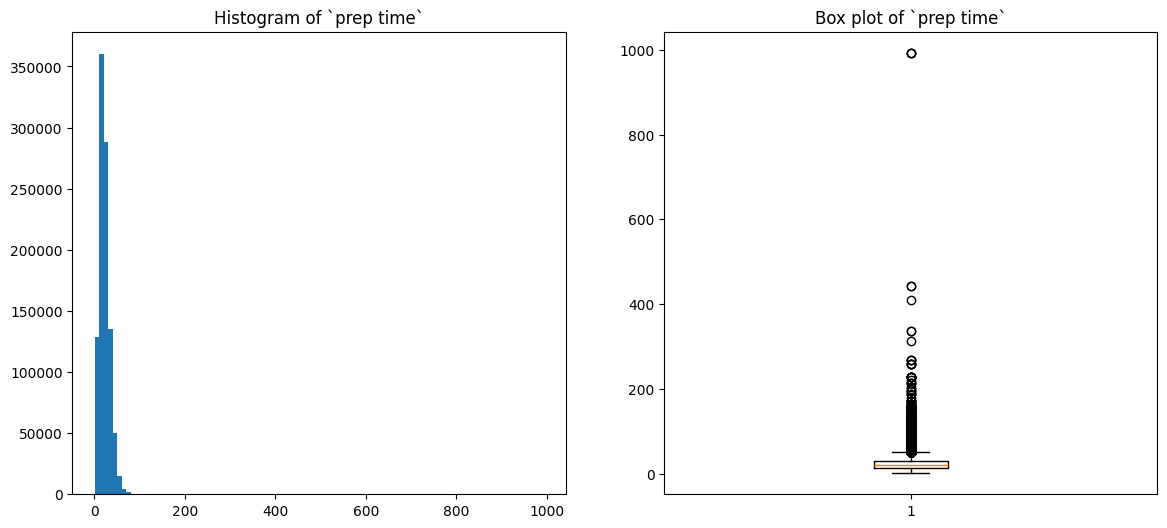

In [15]:
# let's visualize the distribution of labels: both box plot and histograms
import matplotlib.pyplot as plt

y_train = df_train['y']

fig = plt.figure(figsize=(14, 6)) 
fig.add_subplot(1, 2, 1) 

plt.hist(y_train, bins=100)
plt.title("Histogram of `prep time`")

fig.add_subplot(1, 2, 2) 
plt.boxplot(y_train)
plt.title("Box plot of `prep time`")
plt.show()

The histogram clearly demonstrates the skewed distribution of preparation time. Furthermore, the box plot confirms the presence of a relatively large number of outliers. 

In [16]:
import eda
importlib.reload(eda)
mask = eda.iqr_outliers(df_train, 'y', add_column=True)
df_train = df_train[df_train['is_outlier'] == False]

## Feature clasification: Encoding categorical features
Before applying feature enginnering techniques, it is important to understand the type of data we have: categorial, numerical...

In [17]:
df_train.nunique()

order_id             371561
start_prep_date      361364
finish_prep_date     359233
profit                18579
delivery_distance     16682
status_id                 2
planned_prep_time        87
product_id            52475
store_id               1409
y                        51
price                  7999
profit_agg            26825
is_outlier                1
dtype: int64

The features can be classified as follows:

1. Categorical: 
	* product_id
	* store_id
	* order_id: if the product_id does not make a difference, then we will use group by the order id and reduce the number of samples...

2. Continuous:
	* planned prep time
	* price

3. time:
	* start_prep_time: extract the day of the week, the hour, the number of orders a store has received in the last "x" minutes
	* product creation time

Few observations: 

* too many products
* either discard products in general (if most of them were ordered only once or twice) or somehow laverage the frequntly ordered products
* we have few stores which means we can build some 
* the price needs to aggregated across all items in the order


### Product Id and number of products

In [78]:
product_counts = pd.pivot_table(df_train, index='product_id', values='order_id', aggfunc='count')['order_id'].sort_values(ascending=False)
product_counts

product_id
228863     4388
83142      3382
83140      2898
688359     2673
241603     2382
           ... 
876263        1
876403        1
876559        1
876601        1
1318239       1
Name: order_id, Length: 52475, dtype: int64

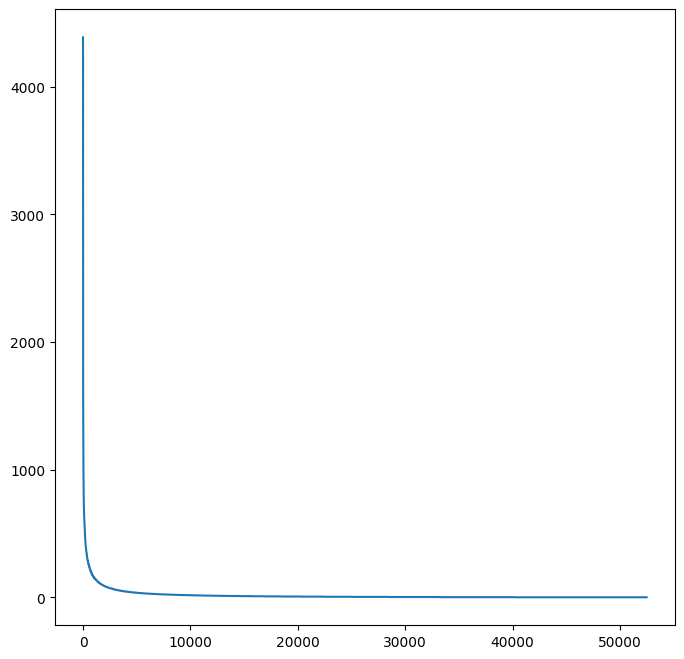

In [79]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 8))
plt.plot(list(range(len(product_counts))), product_counts.values)
plt.show()

In [80]:
# let's see if the number of products correlates with the preparation time
prep_time_per_num_items = pd.pivot_table(data=df_train, values='y', index='order_id', aggfunc=['count', 'mean'])
prep_time_per_num_items.columns = prep_time_per_num_items.columns.droplevel(1) 
prep_time_per_num_items.rename(columns={"count": "num_items", "mean": "y"},inplace=True) 
prep_time_per_num_items['order_y_avg'] = prep_time_per_num_items['y'] / prep_time_per_num_items['num_items']
prep_time_per_num_items = prep_time_per_num_items.sort_values(by='num_items', ascending=True)
prep_time_per_num_items.head()

,num_items,y,order_y_avg
order_id,,,
19660729,1,21.0,21.0
19010633,1,9.0,9.0
19010629,1,1.0,1.0
19010627,1,7.0,7.0
19010625,1,18.0,18.0


In [81]:
FREQUENT_PRODUCTS_IDS = product_counts[product_counts >= 50].index.tolist()
freq_prod_orders = df_train[df_train['product_id'].isin(FREQUENT_PRODUCTS_IDS)]
freq_prod_orders = pd.merge(freq_prod_orders, prep_time_per_num_items.drop(columns='y'), left_on='order_id', right_index=True)
freq_prod_orders.head()

,order_id,start_prep_date,finish_prep_date,profit,delivery_distance,status_id,planned_prep_time,product_id,store_id,y,price,profit_agg,is_outlier,num_items,order_y_avg
0,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99278,3750,23.0,26.070000,10.902,False,3,7.666667
1,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99283,3750,23.0,7.110000,10.902,False,3,7.666667
2,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99285,3750,23.0,7.110000,10.902,False,3,7.666667
3,18671225,2024-05-08 00:02:01,2024-05-08 00:10:29,15.800,560,F,15.0,298529,5863,8.0,31.680436,6.320,False,1,8.000000
4,18671227,2024-05-08 00:01:50,2024-05-08 00:49:19,6.004,4396,F,20.0,399309,8721,47.0,30.020000,6.004,False,1,47.000000


In [82]:
freq_prod_y_stats = pd.pivot_table(freq_prod_orders, values='order_y_avg', index=['product_id'], aggfunc=['mean', 'std', 'median', 'min', 'max'])
freq_prod_y_stats.columns = freq_prod_y_stats.columns.droplevel(1) 

In [83]:
freq_prod_y_stats.head(20)

,mean,std,median,min,max
product_id,,,,,
29049,11.728742,6.866098,10.250000,0.500000,49.0
29060,11.249667,7.258705,9.291667,4.166667,39.0
29139,9.658903,3.573496,9.000000,3.666667,21.0
29140,13.989825,8.744652,11.500000,4.250000,51.0
29141,14.055639,8.536835,12.500000,2.666667,50.0
29848,8.473353,3.756083,8.000000,1.000000,20.5
30299,7.811332,3.405907,7.200000,2.285714,23.0
30302,9.429595,4.542169,9.000000,3.400000,27.0
30336,7.979299,3.852235,7.333333,1.333333,22.0


In [84]:
# let's see how good the sum of the y_avg of each product in comparison to the actual prep time
freq_prod_orders_ = pd.merge(freq_prod_orders, freq_prod_y_stats[['mean', 'median']], left_on='product_id', right_index=True,)
freq_prod_orders_.head()
f = pd.pivot_table(freq_prod_orders_, values=['y', 'mean', 'median'], index='order_id', aggfunc=['sum', 'mean'])
y_train, y_mean_est, y_median_est = f[('mean', 'y')], f[('sum', 'mean')], f[('sum', 'median')]

In [87]:
mse_mean = np.mean(np.abs(y_train.values - y_mean_est)) 
mse_median = np.mean(np.abs((y_train.values - y_median_est))) 
mse_mean, mse_median

(8.990128568502572, 9.235095217414996)

The initial results seem promising. However, as we can see the standar variation of each product is relatively high ($\approx 10$). One possible encoding is to split the label into different intervals and compute the 